# CS4243 Project

1. Clement Ng
2. Kimberley Tay
3. Wayne Tan

## Scraping dataset

1. Images are scraped from google images, duckduckgo images, and unsplash.
2. They are then manually labelled by us.

In [54]:
#from compiled.scraper3 import main

#main()

## Image Preprocessing

In this step, we will be taking a look at
1. The dataset distribution
2. Normalising of dataset
3. Saving the dataset in a .pt extension for easily reproducible results

In [44]:
from PIL import Image
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import time, os, torch

### Checking sizes of images

A few things to note:
1. base_folder defines the folder in which all the images are in.
2. It is assumed that the images are in their respective folders based on their labels, with the folder name being the label, and all of them are in base_folder.

In [45]:
base_folder = './dataset'
classes = os.listdir(base_folder)
classes = [int(i) for i in classes]
classes.sort()

In [46]:
def dataset_stats():
    stats = []
    classes_ = [i for i in classes if i < 11]
    for class_ in classes_:
        folder_path = f'{base_folder}/{class_}'
        files = os.listdir(folder_path)
        for file in files:
            im = Image.open(f'{folder_path}/{file}')
            size = im.size
            stats.append(size + (class_,))
    return np.array(stats)

In [47]:
stats = dataset_stats()

<AxesSubplot:ylabel='Count'>

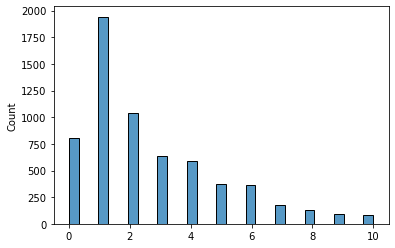

In [56]:
sns.histplot(x=stats[:, 2])

We observe that the amount of dataset for label 1 is much higher than the rest, so the measure we have chosen to adopt here is to deploy undersampling. Furthermore, for the labels >6, the quantity of dataset available is alot less than those <=6, and based on our decision that 6 is a good number to cut off especially because there is not much of a difference with either 10 or 11 people.

<AxesSubplot:ylabel='Count'>

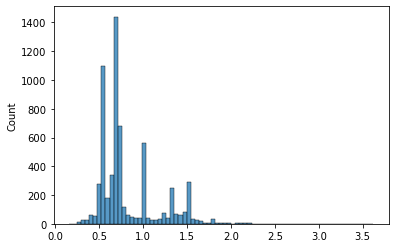

In [59]:
ratios = stats[:, 1] / stats[:, 0]
sns.histplot(x=ratios)

Most of the images lie within a boundary of 0.5 to 1.5 in aspect ratios, and since we decided to conduct undersampling for majority classes, we will prioritise keeping the images whose aspect ratio lie in this range. In other words, the images whose aspect ratios lie outside this range will be removed with priority.

### Normalising Size of images

1. We will be reading the images, converting them to the same size of 256x256, by scaling while retaining aspect ratio, then padding to a square with 0s.
2. If the original image is larger than 256 on either side, it will be scaled down, else the size will remain the same.
3. The dataset will then be saved to a .pt file, and uploaded to a repository so that it can be reproduced easier, instead of uploading all the images as a dataset.
4. This step will only be performed on a local computer with the dataset and does not need to be reproduced when reproducing the results.
5. If there are requests for the dataset used, please email XXX.

In [58]:
def make_square(im, size):
    x, y = im.size
    factor = x / y
    new_size = (size, size)
    if x < y:
        new_size = (int(factor*size), size)
    elif x > y:
        new_size = (size, int(size / factor))
    new_im = Image.new('RGB', (size, size), color=0)
    new_im.paste(im.resize(new_size),
                 (int((size - new_size[0]) / 2), int((size - new_size[1]) / 2)))
    return new_im

In [11]:
def load_dataset(size):
    transformer = transforms.ToTensor()
    dataset = []
    labels = []
    for class_ in classes:
        folder_path = f'{base_folder}/{class_}'
        files = os.listdir(folder_path)
        files.sort()
        for file in files:
            im = Image.open(f'{folder_path}/{file}')
            new_im = make_square(im, size)
            dataset.append(transformer(new_im))
            labels.append(class_)
    dataset = torch.stack(dataset[0:648], dim=0)
    labels = torch.tensor(labels[0:648])
    return dataset, labels

In [12]:
dataset, labels = load_dataset(256)

In [13]:
dataset.size()

torch.Size([648, 3, 256, 256])

In [14]:
torch.save(dataset, 'dataset1.pt')

In [15]:
count = 0
many_black = []
size = dataset.size()
for i in range(size[0]):
    count += dataset[i, :, :, :].count_nonzero()
    if(dataset[i, :, :, :].count_nonzero()) < 98304:
        many_black.append(i)

count/(256*256*3*6480)

tensor(0.0678)

tensor(0)


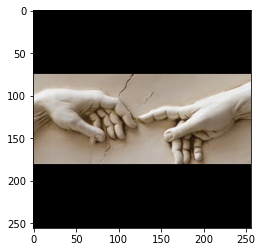

In [20]:
samples = np.random.randint(0, dataset.size()[0], 1)
samples = [many_black[11]]
for sample in samples:
    im = dataset[sample]
    plt.figure()
    plt.imshow(im.numpy().transpose((1,2,0)))
    print(labels[sample])

### Saving as a .pt file

In [19]:
total_size = dataset.size()[0]
train_proportion = 0.8
train_size = int(train_proportion*total_size)

shuffled_indices = np.random.permutation(np.arange(total_size))
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

In [ ]:
train_data = dataset[train_indices, :, :, :]
train_labels = labels[train_indices]
test_data = dataset[test_indices, :, :, :]
test_labels = labels[test_indices]

torch.save(train_data, 'train_data.pt')
torch.save(train_labels, 'train_labels.pt')
torch.save(test_data, 'test_data.pt')
torch.save(test_labels, 'test_labels.pt')

In [20]:
torch.save(dataset, 'dataset.pt')
torch.save(labels, 'labels.pt')

In [10]:
train_data = dataset[:100, :, :, :]

## Training of the model

The main goals of this step is to
1. Perform a Vanilla CNN
2. Try to develop a more advanced structure mainly based on the hierarichal features idea taught in class

In [68]:
import torch.nn as nn

In [70]:
size = np.array([256, 256])

class Vanilla_CNN(nn.Module):
    
    def __init__(self, hidden_dim, output_dim):
        super(Vanilla_CNN, self).__init__()
        
        self.linear_dim = hidden_dim*size.product()
        self.conv = nn.Conv2d(3, hidden_dim, kernel_size=3, padding=1)
        self.linear = nn.Linear(self.linear_dim, output_dim)
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        x = x.view(-1, self.linear_dim)
        x = self.linear(x)
        return x